<a href="https://colab.research.google.com/github/pajonnakuti/pyDataviz/blob/main/Read_netCDF_Viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 52.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [6]:
# === Imports ===
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FuncAnimation


In [9]:
# === Step 1: Read NetCDF ===
# Replace with your filename
ds = xr.open_dataset("/content/drive/MyDrive/PyDataViz/sst.day.mean.2024.nc")

# === Step 2: Display Info ===
print("\n--- Dataset Info ---")
print(ds)

print("\n--- Dimensions ---")
print(ds.dims)

print("\n--- Variables ---")
print(list(ds.variables))


--- Dataset Info ---
<xarray.Dataset> Size: 2GB
Dimensions:  (time: 366, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2024-01-01 2024-01-02 ... 2024-12-31
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 2GB ...
Attributes:
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    institution:    NOAA/National Centers for Environmental Information
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...

--- Dimensions ---
FrozenMappingWarningOnValuesAcce

In [12]:
# Assume variable of interest is SST
sst = ds["sst"]

# === Step 3: Make Subset (example: Indian Ocean) ===
subset = sst.sel(lat=slice(-30, 30), lon=slice(30, 110))

# === Step 4: Plot single frame ===
day0 = subset.isel(time=78)

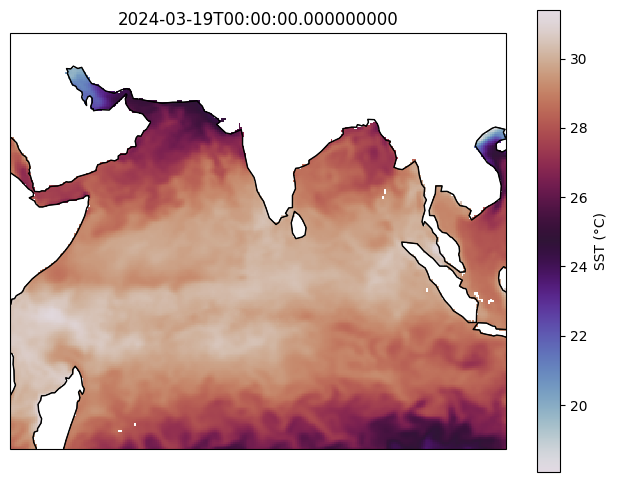

In [21]:
fig, ax = plt.subplots(
    subplot_kw={"projection": ccrs.PlateCarree()},
    figsize=(8, 6)
)
day0.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="twilight", cbar_kwargs={'label': 'SST (°C)'})
ax.coastlines()
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.set_extent([40, 110, -20, 30])  # focus region
plt.title(str(day0["time"].values))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
print(plt.colormaps())

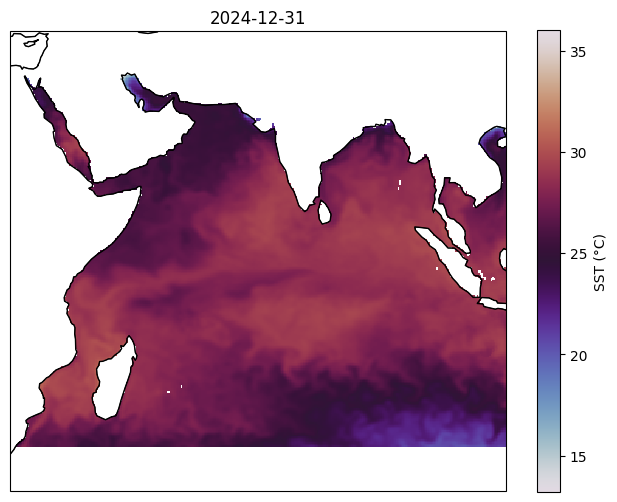

In [24]:
# === Step 5: Create Animation ===
fig, ax = plt.subplots(
    subplot_kw={"projection": ccrs.PlateCarree()},
    figsize=(8, 6)
)
ax.coastlines()
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.set_extent([30, 110, -30, 30])

# Calculate global min and max for fixed colorbar limits
global_min_sst = subset.min().values
global_max_sst = subset.max().values

im = subset.isel(time=0).plot(
    ax=ax, transform=ccrs.PlateCarree(), cmap="twilight", cbar_kwargs={'label': 'SST (°C)'},
    vmin=global_min_sst, vmax=global_max_sst # Set fixed colorbar limits
)

title = ax.set_title("")

def update(frame):
    data = subset.isel(time=frame)
    im.set_array(data.values.flatten())  # update plot
    title.set_text(str(data["time"].values)[:10])
    return [im, title]

ani = FuncAnimation(fig, update, frames=len(subset.time), interval=200, blit=False)

# Save animation as mp4 or gif
#ani.save("/content/drive/MyDrive/PyDataViz/sst_animation.mp4", writer="ffmpeg", dpi=150)
ani.save("sst_animation.gif", writer="imagemagick", dpi=150)

plt.show()

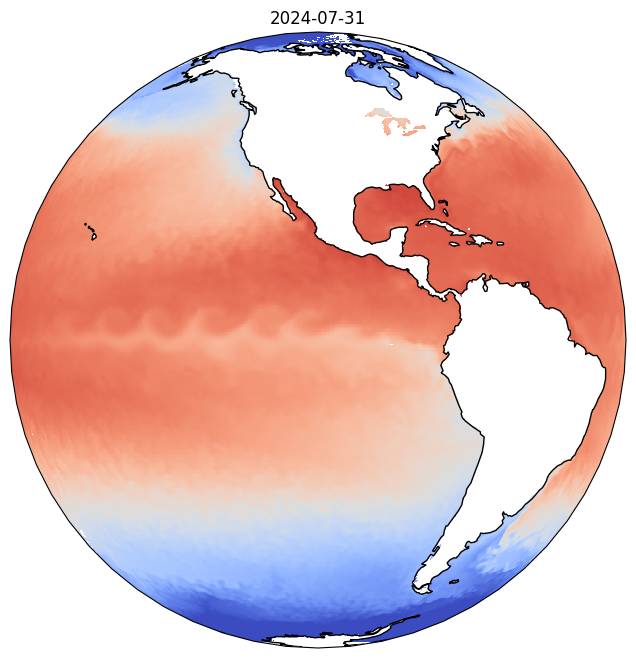

In [27]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.animation import FuncAnimation
import numpy as np

# === Load dataset ===
ds = xr.open_dataset("/content/drive/MyDrive/PyDataViz/sst.day.mean.2024.nc")   # replace with your NetCDF file
sst = ds["sst"]

# Pick random time steps
n_frames = 40
time_indices = np.random.choice(len(sst.time), n_frames, replace=False)

# Setup figure
fig = plt.figure(figsize=(8, 8))


# === Update function ===
def update(frame):
    # Clear previous frame artists
    plt.clf() # Clear the figure

    # Rotate globe with frame index
    central_lon = (60 + frame * 5) % 360
    # Create a new axes with the updated projection
    ax = plt.axes(projection=ccrs.Orthographic(central_longitude=central_lon, central_latitude=0))
    ax.set_global()
    ax.coastlines()

    # Pick random time step
    t = time_indices[frame % n_frames]
    data = sst.isel(time=t)

    # Update the plot data
    im = ax.pcolormesh(
        data["lon"], data["lat"], data,
        transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'SST (°C)'},
        cmap="coolwarm"
    )
    title = ax.set_title(str(data["time"].values)[:10])
    # Return the artists that were updated
    return [im, title]


# === Animate ===
ani = FuncAnimation(fig, update, frames=n_frames, interval=250, blit=False)

# Save output
ani.save("/content/drive/MyDrive/PyDataViz/sst_globe_rotation_time.mp4", writer="ffmpeg", dpi=150)
# ani.save("/content/drive/MyDrive/PyDataViz/sst_globe_rotation_time.gif", writer="imagemagick")

plt.show()